# Movie Recommendation

## IMDB movie recommendation notebook

#### Author/s: Ruturaj Kiran Vaidya, Brian McClannahan, and Matthew Taylor
(Add you name if you edit/improve)

In [1]:
# Imports

# General

import os
import re
import pandas as pd
import numpy as np
import random
import pickle

# graphs

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Model
# sklearn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction import text

In [2]:
from matplotlib import pyplot as plt

In [3]:
train = pd.read_json("TrainMovieDetails.json")
test = pd.read_json("TestMovieDetails.json")

In [4]:
train.keys()

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Episode', 'Genre', 'Language', 'Metascore', 'Plot', 'Poster',
       'Production', 'Rated', 'Ratings', 'Released', 'Response', 'Runtime',
       'Season', 'Title', 'Type', 'Website', 'Writer', 'Year', 'imdbID',
       'imdbRating', 'imdbVotes', 'seriesID', 'totalSeasons'],
      dtype='object')

In [5]:
test.keys()

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Episode', 'Error', 'Genre', 'Language', 'Metascore', 'Plot', 'Poster',
       'Production', 'Rated', 'Ratings', 'Released', 'Response', 'Runtime',
       'Season', 'Title', 'Type', 'Website', 'Writer', 'Year', 'imdbID',
       'imdbRating', 'imdbVotes', 'seriesID', 'totalSeasons'],
      dtype='object')

In [6]:
del test["Error"]

In [7]:
test.head()

,Actors,Awards,BoxOffice,Country,DVD,Director,Episode,Genre,Language,Metascore,...,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes,seriesID,totalSeasons
0,"Kevin Costner, Ashton Kutcher, Sela Ward, Meli...",1 win & 4 nominations.,"$54,983,983",USA,23 Jan 2007,Andrew Davis,NaN,"Action, Adventure, Drama",English,53,...,The Guardian,movie,N/A,Ron L. Brinkerhoff,2006,tt0406816,6.9,"84,017",NaN,NaN
1,"Albert Finney, Tom Courtenay, Edward Fox, Zena...",Nominated for 5 Oscars. Another 5 wins & 12 no...,N/A,UK,06 Apr 2004,Peter Yates,NaN,Drama,English,N/A,...,The Dresser,movie,N/A,"Ronald Harwood (screenplay), Ronald Harwood (b...",1983,tt0085461,7.7,"4,285",NaN,NaN
2,"S. Epatha Merkerson, Marcus Carl Franklin, Yas...",Won 1 Golden Globe. Another 29 wins & 41 nomin...,N/A,USA,23 Aug 2005,George C. Wolfe,NaN,"Drama, Music",English,N/A,...,Lackawanna Blues,movie,N/A,"Ruben Santiago-Hudson (play), Ruben Santiago-H...",2005,tt0407936,7.9,"2,150",NaN,NaN
3,"Julie Andrews, Rock Hudson, Jeremy Kemp, Lance...",Nominated for 3 Oscars. Another 1 win & 4 nomi...,N/A,USA,25 Oct 2005,Blake Edwards,NaN,"Comedy, Drama, Musical, Romance, War","English, German",N/A,...,Darling Lili,movie,N/A,"Blake Edwards, William Peter Blatty",1970,tt0065611,6.1,"1,826",NaN,NaN
4,Mel Blanc,N/A,N/A,USA,N/A,Robert McKimson,NaN,"Family, Animation, Short",English,N/A,...,Acrobatty Bunny,movie,N/A,Warren Foster (story),1946,tt0038286,7.3,663,NaN,NaN


In [8]:
train.head()

,Actors,Awards,BoxOffice,Country,DVD,Director,Episode,Genre,Language,Metascore,...,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes,seriesID,totalSeasons
0,"Seth Allen, John Bakos, Mari-Claire Charba, Pe...",N/A,N/A,USA,N/A,Tom O'Horgan,NaN,Comedy,English,N/A,...,Futz,movie,N/A,"Rochelle Owens (play), Joseph Stefano (screenp...",1969,tt0064354,4.8,50,NaN,NaN
1,"Jane Fonda, Robert De Niro, Swoosie Kurtz, Mar...",N/A,N/A,"USA, Canada",13 Jan 2004,Martin Ritt,NaN,"Drama, Romance",English,N/A,...,Stanley & Iris,movie,N/A,"Pat Barker (novel), Harriet Frank Jr. (screenp...",1990,tt0100680,6.3,"6,502",NaN,NaN
2,"Christopher Walken, Jason Connery, Carmela Mar...",N/A,N/A,USA,09 Aug 2005,Eugene Marner,NaN,"Fantasy, Musical, Family",English,N/A,...,Puss in Boots,movie,N/A,"Charles Perrault (fairy tale ""Le chat botté""),...",1988,tt0177606,6.4,537,NaN,NaN
3,N/A,N/A,N/A,N/A,N/A,N/A,NaN,N/A,N/A,N/A,...,#DUPE#,movie,N/A,N/A,1972,tt0068444,N/A,N/A,NaN,NaN
4,"Shemp Howard, Larry Fine, Moe Howard, Christin...",N/A,N/A,USA,N/A,Edward Bernds,NaN,"Comedy, Short",English,N/A,...,Who Done It?,movie,N/A,"Edward Bernds (story), Edward Bernds (screenplay)",1949,tt0042042,8.2,335,NaN,NaN


In [9]:
combined = pd.concat([train, test], ignore_index=True)
movies = combined[["imdbID", "Title", "Ratings", "imdbRating", "imdbVotes", "Language", "Genre"]].dropna()
movies.drop_duplicates(subset=['imdbID'], keep=False, inplace=True)

In [10]:
movies.tail()

,imdbID,Title,Ratings,imdbRating,imdbVotes,Language,Genre
7029,tt0258760,Lammbock,"[{'Source': 'Internet Movie Database', 'Value'...",7.3,"10,180",German,Comedy
7030,tt0146455,Babylon 5: A Call to Arms,"[{'Source': 'Internet Movie Database', 'Value'...",7.2,"4,976",English,"Action, Adventure, Drama, Sci-Fi"
7031,tt0432047,Sarkar,"[{'Source': 'Internet Movie Database', 'Value'...",7.7,"14,199","Hindi, Marathi","Crime, Drama"
7032,tt0109515,Cyber Tracker,"[{'Source': 'Internet Movie Database', 'Value'...",3.5,971,English,"Action, Sci-Fi"
7033,tt0485161,Totally Awesome,"[{'Source': 'Internet Movie Database', 'Value'...",5.2,"1,625",English,Comedy


In [11]:
movies.shape

(6914, 7)

### Encoding genres

In [12]:
# split genres and printing
genres = set([j.replace(" ", "") for i in [i.split(",") for i in movies['Genre']] for j in i])
print(genres)
print(len(genres))

{'Adventure', 'Reality-TV', 'Sport', 'N/A', 'Mystery', 'Biography', 'Adult', 'Drama', 'Western', 'History', 'Action', 'Musical', 'Fantasy', 'Game-Show', 'Sci-Fi', 'News', 'Talk-Show', 'Comedy', 'Documentary', 'Crime', 'Romance', 'Short', 'Thriller', 'War', 'Animation', 'Family', 'Film-Noir', 'Music', 'Horror'}
29


In [13]:
# Add columns based on new generes
genres_dic = {j:[1 if j in i else 0 for i in movies["Genre"]] for j in genres}
# There is an N/A genre - removing
del genres_dic['N/A']
del genres_dic['Talk-Show']
del genres_dic['News']
del genres_dic['Game-Show']
# Plotting movies per genre
data = [go.Bar(
            x=list(genres_dic.keys()),
            y=[sum(i) for i in genres_dic.values()]
    )]
fig = go.Figure(data=data)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title="Movies per Genre",
    xaxis_title="Genres",
    yaxis_title="Number of Movies",
)

iplot(fig)

### Similarly encoding languages

In [14]:
# split genres and printing
languages = set([j for i in [i.split(",") for i in movies['Language']] for j in i])
print(len(languages))

187


In [15]:
# Add columns based on new generes
languages_dic = {j:[1 if j in i else 0 for i in movies["Language"]] for j in languages}
# Plotting movies per genre
data = [go.Bar(
            x=list(languages_dic.keys()),
            y=[sum(i) for i in languages_dic.values()]
    )]
fig = go.Figure(data=data)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title="Movies per Language",
    xaxis_title="Languages",
    yaxis_title="Number of Movies",
)

iplot(fig)

### Above graph is interactive - and I know there are so many English movies!
### Hence we will not select languages for our analysis

In [16]:
# Now we will add encoded generes and languages
for k,v in genres_dic.items():
    movies[k]=v
#for k,v in languages_dic.items():
#    movies[k]=v
# Dropping rows with no genres listed
movies = movies[movies.Genre != "N/A"]
# We don't need genres column anymore
del movies["Genre"]
del movies["Language"]

# Also converting imdb votes to numeric
movies["imdbVotes"] = movies['imdbVotes'].str.replace(",", "").astype(int)

# Normalize rating
for index, row in movies.iterrows():
    movies.loc[index, 'imdbRating'] = float(row['imdbRating']) / 10

movies = movies.reset_index(drop=True)
    
movies.tail()

,imdbID,Title,Ratings,imdbRating,imdbVotes,Adventure,Reality-TV,Sport,Mystery,Biography,...,Crime,Romance,Short,Thriller,War,Animation,Family,Film-Noir,Music,Horror
6575,tt0258760,Lammbock,"[{'Source': 'Internet Movie Database', 'Value'...",0.73,10180,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6576,tt0146455,Babylon 5: A Call to Arms,"[{'Source': 'Internet Movie Database', 'Value'...",0.72,4976,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6577,tt0432047,Sarkar,"[{'Source': 'Internet Movie Database', 'Value'...",0.77,14199,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6578,tt0109515,Cyber Tracker,"[{'Source': 'Internet Movie Database', 'Value'...",0.35,971,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6579,tt0485161,Totally Awesome,"[{'Source': 'Internet Movie Database', 'Value'...",0.52,1625,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Text Vectorization

In [17]:
# Instantiate vectorizers
stop_words = text.ENGLISH_STOP_WORDS.union(['movie', 'film', 'like', 'love', 'just', 'good', 'time', 'really',
                                            'story', 'bad', 'movies', 'don', 'people', 'make', 'great',
                                            'way', 'characters', 'character', 'watch', 'films', 'acting',
                                            'seen', 'think', 'does', 'little', 'plot', 'does', 'did',
                                            've' 'doesn', 'know', 'life', 'end', 'scene', 'man', 've',
                                            'say', 'thing', 'didn', 'things', 'better', 'best', 'scenes'])
count_vectorizer = text.CountVectorizer(stop_words=stop_words)
tfidf_vectorizer = text.TfidfVectorizer(stop_words=stop_words)

In [18]:
# Get the movie ids of each review
# Note: You must place the "test" and "train" directories from the dataset
#       available here: http://ai.stanford.edu/~amaas/data/sentiment/ in 
#       a directory named data/raw for these cells to work
test_neg_movie_ids = [x.split('/')[4] for x in open('../../data/raw/test/urls_neg.txt').readlines()]
test_pos_movie_ids = [x.split('/')[4] for x in open('../../data/raw/test/urls_pos.txt').readlines()]
train_neg_movie_ids = [x.split('/')[4] for x in open('../../data/raw/train/urls_neg.txt').readlines()]
train_pos_movie_ids = [x.split('/')[4] for x in open('../../data/raw/train/urls_pos.txt').readlines()]

In [19]:
# master list of all reviews, to be appended to movies dataframe
reviews = [[] for _ in range(len(movies))]

# regex to remove html from reviews
html_regex = re.compile(r'<[^>]+>')

print('Loading reviews...', flush=True)

# get the names of files containing reviews
test_neg_review_files = os.listdir('../../data/raw/test/neg')
for i in range(len(test_neg_movie_ids)):
    
    movie_id = test_neg_movie_ids[i]
    
    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdbID.values:
        continue
        
    # get the movie's dataframe index
    index = movies.loc[movies.imdbID == movie_id].index[0]
    
    # load review and remove html
    review_text = open('../../data/raw/test/neg/{}'.format(test_neg_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)
    
    # assign review to movie
    reviews[index].append(review_text)
    
test_pos_review_files = os.listdir('../../data/raw/test/pos')
for i in range(len(test_pos_movie_ids)):
    
    movie_id = test_pos_movie_ids[i]
    
    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdbID.values:
        continue
        
    # get the movie's dataframe index
    index = movies.loc[movies.imdbID == movie_id].index[0]
    
    # load review and remove html
    review_text = open('../../data/raw/test/pos/{}'.format(test_pos_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)
    
    # assign review to movie
    reviews[index].append(review_text)
    
train_neg_review_files = os.listdir('../../data/raw/train/neg')
for i in range(len(train_neg_movie_ids)):
    
    movie_id = train_neg_movie_ids[i]
    
    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdbID.values:
        continue
        
    # get the movie's dataframe index
    index = movies.loc[movies.imdbID == movie_id].index[0]
    
    # load review and remove html
    review_text = open('../../data/raw/train/neg/{}'.format(train_neg_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)
    
    # assign review to movie
    reviews[index].append(review_text)
    
train_pos_review_files = os.listdir('../../data/raw/train/pos')
for i in range(len(train_pos_movie_ids)):
    
    movie_id = train_pos_movie_ids[i]
    
    # ignore reviews for movies that have removed from the dataframe
    if movie_id not in movies.imdbID.values:
        continue
        
    # get the movie's dataframe index
    index = movies.loc[movies.imdbID == movie_id].index[0]
    
    # load review and remove html
    review_text = open('../../data/raw/train/pos/{}'.format(train_pos_review_files[i]), encoding='utf8').read()
    review_text = html_regex.sub(' ', review_text)
    
    # assign review to movie
    reviews[index].append(review_text)
    
print('Done', flush=True)

Loading reviews...
Done


In [20]:
# concatenate results, append to dataframe
reviews = [' '.join(i) for i in reviews]
movies['reviews'] = reviews

In [21]:
# vectorize reviews
count_vectors = count_vectorizer.fit_transform(reviews)
tfidf_vectors = tfidf_vectorizer.fit_transform(reviews)

### Using K-means clustering

In [22]:
# Here I am selecting ratings, votes, genres and languages to train
X = movies.drop(columns=['imdbVotes', 'reviews']).replace([np.inf, -np.inf], np.nan).dropna().iloc[:,3:].to_numpy()
# I am selecting 30 clusters based on number of languages, but this can be changed later
# I roughly selected the number of clusters, but this can be changed for e.g. based on genres
kmeans = KMeans(n_clusters=15, random_state=4).fit(X)
Y_Kmeans = kmeans.fit_predict(X)

In [23]:
# create kmeans models based on reviews
if os.path.exists('pickle/kmeans_count'):
    kmeans_count = pickle.load(open('pickle/kmeans_count', 'rb'))
else:
    
    if not os.path.exists('pickle'):
        os.mkdir('pickle')
        
    kmeans_count = KMeans(n_clusters=8, random_state=4).fit(count_vectors)
    pickle.dump(kmeans_count, open('pickle/kmeans_count', 'wb'))
    
if os.path.exists('pickle/kmeans_tfidf'):
    kmeans_tfidf = pickle.load(open('pickle/kmeans_tfidf', 'rb'))
else:
    kmeans_tfidf = KMeans(n_clusters=8, random_state=4).fit(tfidf_vectors)
    pickle.dump(kmeans_tfidf, open('pickle/kmeans_tfidf', 'wb'))

### Using DBSCAN

In [24]:
dbscan = DBSCAN(min_samples=10).fit(X)

In [25]:
print(np.unique(dbscan.labels_))
dbscan_dic = {i:[] for i in dbscan.labels_}
[dbscan_dic[i].append(list(movies["Title"])[c]) for c, i in enumerate(dbscan.labels_)]
print([len(i) for i in dbscan_dic.values()])

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118]
[368, 249, 1926, 50, 98, 55, 21, 42, 37, 89, 23, 92, 38, 573, 18, 161, 14, 23, 48, 31, 71, 10, 216, 20, 14, 14, 23, 16, 34, 18, 21, 140, 34, 13, 16, 18, 67, 43, 10, 96, 14, 20, 15, 15, 15, 15, 191, 16, 22, 15, 21, 13, 33, 16, 14, 11, 38, 20, 20, 19, 15, 12, 34, 14, 20, 23, 27, 22, 58, 14, 12, 41, 15, 20, 19, 27, 17, 22, 23, 36, 11, 13, 41, 10, 17, 19, 10, 16, 10, 18, 30, 53, 20, 11, 11, 33, 16, 10, 53, 16, 12, 16, 12, 34, 13, 13, 26, 18, 14, 13, 13, 10, 15, 16, 14, 13, 11, 13, 12, 10]


Looks like there are too many outlier movies for dbscan to work.

### Agglomerative Clustering

In [26]:
ac = AgglomerativeClustering(n_clusters = 30).fit(X)

In [27]:
print(np.unique(ac.labels_))
ac_dic = {i:[] for i in ac.labels_}
[ac_dic[i].append(list(movies["Title"])[c]) for c, i in enumerate(ac.labels_)]
print([len(i) for i in ac_dic.values()])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[386, 367, 213, 141, 163, 188, 161, 245, 156, 177, 227, 133, 573, 374, 132, 153, 248, 176, 200, 166, 390, 186, 221, 229, 133, 185, 215, 124, 127, 191]


### Recommendation Function

In [28]:
comb_dic = {i:[] for i in kmeans.labels_}
[comb_dic[i].append(list(movies["Title"])[c]) for c, i in enumerate(kmeans.labels_)]
print([len(i) for i in comb_dic.values()])

[782, 487, 212, 403, 330, 462, 214, 308, 563, 513, 1081, 290, 468, 245, 222]


In [29]:
# Simplest function - note that it may give same value as recommendation as it randomly selects the movie
# This can be changed later
def movie_recommendation(x,model,dic,df):
    return random.choice(dic[model.labels_[list(df["Title"]).index(x)]])

In [30]:
def all_movie_recommendations(x,model,dic,df):
    return dic[model.labels_[list(df["Title"]).index(x)]]

In [31]:
#Recommends movies based on the intersection of all three clustering methods
def combined_approach(k_rec,d_rec,a_rec):
    combo_list = [value for value in k_rec if value in d_rec]
    combo_list = [value for value in combo_list if value in a_rec]
    return combo_list

In [32]:
def compare_techniques(movie):
    print("Comparing techniques on movie", movie, "with genres", combined[combined.Title == movie].Genre.values)
    k_list = all_movie_recommendations(movie,kmeans,comb_dic,movies)
    d_list = all_movie_recommendations(movie,dbscan,dbscan_dic,movies)
    a_list = all_movie_recommendations(movie,ac,ac_dic,movies)
    kmeans_rec = random.choice(k_list)
    dbscan_rec = random.choice(d_list)
    ac_rec = random.choice(a_list)
    combo_rec = random.choice(combined_approach(k_list,d_list,a_list))
    print("Kmeans recommends", kmeans_rec, "with genres", combined[combined.Title == kmeans_rec].Genre.values)
    print("DBSCAN recommends", dbscan_rec, "with genres", combined[combined.Title == dbscan_rec].Genre.values)
    print("AC recommends", ac_rec, "with genres", combined[combined.Title == ac_rec].Genre.values)
    print("Combo recommends", combo_rec, "with genres", combined[combined.Title == combo_rec].Genre.values)

In [33]:
movie = "Totally Awesome"
kmeans_rec = all_movie_recommendations(movie,kmeans,comb_dic,movies)
dbscan_rec = all_movie_recommendations(movie,dbscan,dbscan_dic,movies)
ac_rec = all_movie_recommendations(movie,ac,ac_dic,movies)
print(len(kmeans_rec), len(dbscan_rec), len(ac_rec))
c = combined_approach(kmeans_rec,dbscan_rec,ac_rec)
print(len(c))

782 368 386
368


In [34]:
compare_techniques("Totally Awesome")

Comparing techniques on movie Totally Awesome with genres ['Comedy']
Kmeans recommends Family Guy with genres ['Animation, Comedy']
DBSCAN recommends The Dark Horse with genres ['Comedy']
AC recommends Gimme an 'F' with genres ['Comedy']
Combo recommends Four Kings with genres ['Comedy']


In [35]:
compare_techniques("Star Wars: Episode VI - Return of the Jedi")

Comparing techniques on movie Star Wars: Episode VI - Return of the Jedi with genres ['Action, Adventure, Fantasy, Sci-Fi']
Kmeans recommends Motocrossed with genres ['Action, Adventure, Family']
DBSCAN recommends The Honkers with genres ['Western, Action, Comedy, Drama']
AC recommends Blade with genres ['Action, Horror, Sci-Fi']
Combo recommends Star Wars: Episode VI - Return of the Jedi with genres ['Action, Adventure, Fantasy, Sci-Fi']


In [36]:
compare_techniques("Good Will Hunting")

Comparing techniques on movie Good Will Hunting with genres ['Drama, Romance']
Kmeans recommends The Best of Everything with genres ['Drama, Romance']
DBSCAN recommends The Age of Innocence with genres ['Drama, Romance']
AC recommends The Woman He Loved with genres ['Drama, Romance']
Combo recommends Red Dirt with genres ['Drama, Romance']


In [37]:
# Record clusters for each movie, to aid recommendation function

kmeans_count_clusters = []
kmeans_tfidf_clusters = []

kmeans_count.predict(count_vectorizer.transform([movies.reviews.values[0]]))

for r in movies.reviews.values:
    c = count_vectorizer.transform([r])
    t = tfidf_vectorizer.transform([r])
    
    kmeans_count_clusters.append(kmeans_count.predict(c)[0])
    kmeans_tfidf_clusters.append(kmeans_tfidf.predict(t)[0])
    
movies['kmeans_count_cluster'] = kmeans_count_clusters
movies['kmeans_tfidf_cluster'] = kmeans_tfidf_clusters

Here, we define a function that recommends movies based on reviews on those movies. It works by randomly selecting three other movies from the cluster that the given movie belongs to.

In [38]:
# Review recommendation function declaration
def recommend_by_reviews(movie_title):
    
    c_cluster = movies.loc[movies.Title == movie_title].kmeans_count_cluster.values[0]
    t_cluster = movies.loc[movies.Title == movie_title].kmeans_tfidf_cluster.values[0]
    
    possible_count_recommendations = list(movies.loc[movies.kmeans_count_cluster == c_cluster].Title.values)
    possible_tfidf_recommendations = list(movies.loc[movies.kmeans_tfidf_cluster == t_cluster].Title.values)
    
    possible_count_recommendations.remove(movie_title)
    possible_tfidf_recommendations.remove(movie_title)
    
    c = random.sample(possible_count_recommendations, 3)
    t = random.sample(possible_tfidf_recommendations, 3)
    
    print('Finding recommendations for "{}", (count cluster: {}, tfidf cluster: {})'.format(movie_title, c_cluster, t_cluster))
    print('Count vectorizer recommends "{}", "{}", and "{}"'.format(c[0], c[1], c[2]))
    print('Tfidf vectorizer recommends "{}", "{}", and "{}"'.format(t[0], t[1], t[2]))

Before we check the recommendations, it's worth examining the size/distribution of each of the clusters. Doing this shows that the count vectorizer is highly non-uniform. Over half of the movies are placed in a single cluster. The TFIDF vectorizer, on the other hand, is much more uniform.

In [39]:
c = [0] * 8
t = [0] * 8

for i in list(movies.kmeans_count_cluster.values):
    c[i] += 1
    
for i in list(movies.kmeans_tfidf_cluster.values):
    t[i] += 1

print('Movies per cluster for count vectorizer:')
print(c)
print('\nMovies per cluster for tfidf vectorizer:')
print(t)

Movies per cluster for count vectorizer:
[21, 194, 1, 5, 237, 1492, 569, 4061]

Movies per cluster for tfidf vectorizer:
[89, 1712, 275, 94, 142, 26, 1203, 3039]


To further examine the contents of the clusters, we can print the words whose encodings are the closest to each of the cluster centers. This shows that many clusters have their own distinct characteristics, while other cluster centers are rather close to each other.

In [40]:
print('Top 10 words in each count vectorizer cluster:')
count_centers = kmeans_count.cluster_centers_.argsort()[:, ::-1]
word_encodings = count_vectorizer.get_feature_names()

for i in range(8):
    print('Cluster {}: '.format(i), end='')
    for j in count_centers[i, :9]:
        print('{}, '.format(word_encodings[j]), end='')
    print(word_encodings[count_centers[i, 9]])

print('\nTop 10 words in each tfidf vectorizer cluster:')
tfidf_centers = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
word_encodings = tfidf_vectorizer.get_feature_names()

for i in range(8):
    print('Cluster {}: '.format(i), end='')
    for j in tfidf_centers[i, :9]:
        print('{}, '.format(word_encodings[j]), end='')
    print(word_encodings[tfidf_centers[i, 9]])
    
# make room for visualizations
del test_neg_movie_ids
del test_pos_movie_ids
del train_neg_movie_ids
del train_pos_movie_ids
del kmeans_count
del kmeans_tfidf
del word_encodings

Top 10 words in each count vectorizer cluster:
Cluster 0: zombie, zombies, dead, horror, video, music, actually, action, watching, doesn
Cluster 1: horror, 10, doesn, actually, director, watching, real, old, new, lot
Cluster 2: cinderella, disney, fairy, mice, prince, ball, step, classic, stepmother, mother
Cluster 3: davis, mildred, jane, hospital, bette, years, howard, version, philip, performance
Cluster 4: years, real, world, young, work, new, makes, old, war, series
Cluster 5: real, watching, doesn, actors, old, director, going, funny, actually, work
Cluster 6: funny, real, actors, doesn, watching, years, work, actually, director, makes
Cluster 7: watching, funny, actors, actually, 10, director, doesn, real, old, look

Top 10 words in each tfidf vectorizer cluster:
Cluster 0: zombie, seagal, zombies, steven, dead, action, horror, gore, worst, budget
Cluster 1: real, actors, years, series, old, director, funny, watching, work, 10
Cluster 2: funny, comedy, jokes, humor, laugh, sandl

Some of the most distinct clusters are those that describe horror movies. Recommending those may yield the best results. As shown below, recommendations for a movie called 'The Zombie Chronicles' include 'A Nightmare on Elm Street 5' and 'The Manson Family', which seem appropriate.

In [41]:
recommend_by_reviews('The Zombie Chronicles')

Finding recommendations for "The Zombie Chronicles", (count cluster: 0, tfidf cluster: 0)
Count vectorizer recommends "The Mad Monster", "The Wicker Man", and "The Naked Brothers Band: The Movie"
Tfidf vectorizer recommends "Thumbtanic", "Veer-Zaara", and "Yön saalistajat"


Other kinds of movies yield less impressive results. The count vectorizer results for a movie called 'A Little Princess' seem like they have nothing to do with that movie. Inspection reveals that it belongs to the mega-cluster present in the count vectorizer clustering algorithm. The TFIDF vectorizer mentions a movie named 'Penny Princess', which is on the right track, though the other two movies are nothing like the given movie.

In [42]:
recommend_by_reviews('A Little Princess')

Finding recommendations for "A Little Princess", (count cluster: 7, tfidf cluster: 3)
Count vectorizer recommends "Mickybo and Me", "The Maxx", and "Where It's At"
Tfidf vectorizer recommends "Blindsight", "Princesse Tam-Tam", and "Blonde Venus"


Going back to the contents of the reviews for these movies reveals something worth noting. Many reviews contain extremely similar wording. Most reviews are long the lines of 'This movie was great, I loved it! The actors were so believable'. While this is obviously a glowing review and can help a sentiment analysis tool learn the meaning of the words 'great' and 'loved', it does little to make movie recommendations, considering this review could potentially be given to a movie of any kind.

## Visualizations

In [43]:
df_pie_visualization = movies.drop(columns=["Title","imdbID","Ratings","imdbRating","imdbVotes", "reviews", "kmeans_count_cluster", "kmeans_tfidf_cluster"])
df_pie_visualization

,Adventure,Reality-TV,Sport,Mystery,Biography,Adult,Drama,Western,History,Action,...,Crime,Romance,Short,Thriller,War,Animation,Family,Film-Noir,Music,Horror
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [44]:
dict_genres = dict()
total = 0
for column in df_pie_visualization.columns:
    count = df_pie_visualization[column].sum()
    total += count
    dict_genres[column] = count

In [45]:
data = []
labels = []
for key in dict_genres.keys():
    labels.append(key)
    data.append(dict_genres[key]/total)
label_count = len(labels)
other = 0
i = 0
while i < len(data):
    if data[i] < .02:
        other += data[i]
        del data[i]
        del labels[i]
    else:
        i += 1
print(sum(data))
print(data)
for i in range(len(data)):
    data[i] = data[i]/sum(data)
print(sum(data))
print(data)

0.8624022655913316
[0.04389583205072955, 0.03570768946623161, 0.19275995813581234, 0.06655174536723511, 0.0324447454288001, 0.03946315335836976, 0.12780890229637382, 0.05547004863633565, 0.07369328326048144, 0.0786800467893862, 0.028750846518500277, 0.02733485193621868, 0.05984116234685711]
0.949764824265371
[0.05089948600799544, 0.041071366853323625, 0.22035511843466996, 0.07375259819675853, 0.03567059381952079, 0.043233482295259994, 0.13944384770838833, 0.059761090161116734, 0.07902868572572012, 0.08389646229301147, 0.030487422535951297, 0.02893262219449943, 0.06323204803915526]


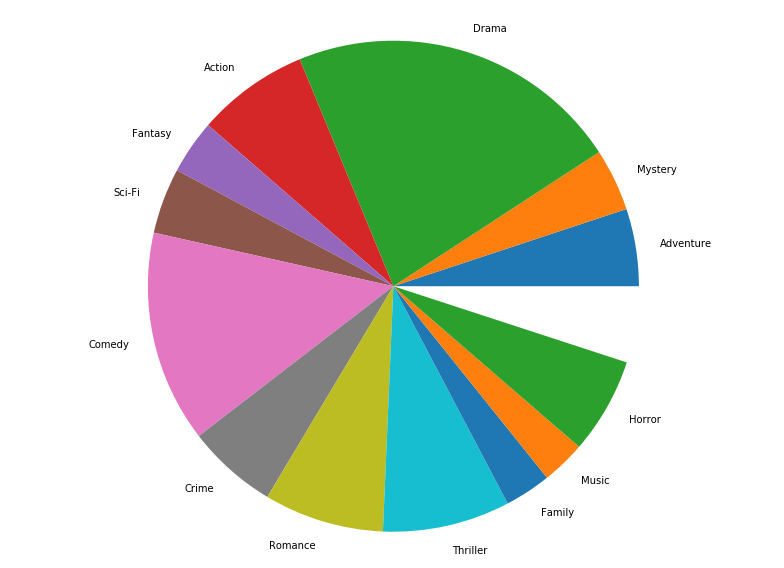

In [46]:
fig_pie,ax_pie = plt.subplots(figsize=(11,8))
plt.pie(data,radius=4.0,labels=labels)
plt.axis('equal')
plt.tight_layout()
plt.show()